# Xe-100 Serpent Results Analysis
This notebook performs analysis the reactor physics and 
performance of an MMR-like reactor
using different compositions of HALEU. The compositions are:
* Pure (U-235 and U-238 are the only uranium isotopes)
* EBR-II (HALEU produced from downblended EBR-II spent fuel)
* Y-12 (HALEU prodced from downblended HEU at Y-12)

The reactor physics/performance metrics considered include:
* k-eff
* neutron flux
* beta-eff
* temperature feedback coefficients. 

Each of these metrics are determined for the intial burnup step. The 
reactor is assumed to be in an isothermal state at 800K, except for the material 
temperatures varied to determine the temperature feedback coefficients. When 
calculating the temperature feedback coefficients, the fuel, coolant, moderator, 
and total fedback coefficients are calculated by varying the respective
material temperatures between 700 (A), 750 (B), 800 (C), 850 (D), and 900 (E) K.
The naming convention for the temeprature variations are fuel, coolant, moderator, 
such that ACC would mean that the fuel is at 700 K, the coolant is at 800 K, 
and the moderator is at 800 K. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import serpentTools
from serpentTools.settings import rc
import pandas as pd

In [2]:
def calculate_rho(k):
    '''
    Calculate the reactivity (rho) based on k
    
    Parameters:
    -----------
    k: int, float
        k-eff value 
    
    Returns:
    --------
    rho: float, int
       reactivity
    '''
    rho = (k-1)/k
    return rho

def rho_error_propagation(k, k_error):
    '''
    Performs error propagation for the calculation 
    of the temperature feedback coefficients
    
    Parameters:
    -----------
    k: int, float
        k-eff
    k_error: int, float
        error in k-eff 
    
    Returns
    -------
    prop_error: int, float
        propagated error
    '''
    prop_error = np.sqrt(k_error**2 * (1/k)**2)
    return prop_error

def calculate_sums(x, y):
    '''
    Calculate sums and sums of squares
    used in linear regression
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
    
    Returns:
    --------
    sum_x: float
        sum of values in x
    sum_y: float
        sum of values in y
    sum_xy: float
        sum of x*y
    sum_x_squared: float
        sum of (x**2)
    '''
    n = len(temps)
    sum_x = 0; 
    sum_x_squared = 0
    sum_y = 0
    sum_xy = 0
    for ii in range(0, n):
        sum_x += x[ii]
        sum_y += y[ii]
        sum_xy += x[ii]*y[ii]
        sum_x_squared += x[ii]**2
        
    return sum_x, sum_y, sum_xy, sum_x_squared

def calculate_m(x, y):
    '''
    Calcualtes slope of a linear fit to data
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
        
    Returns:
    --------
    m: float
        slope of the line
    '''
    n = len(x)
    sum_x, sum_y, sum_xy, sum_x_squared = calculate_sums(x, y)
    m = ((n*sum_xy) - sum_x*sum_y)/(n*sum_x_squared - sum_x**2)
    
    return m

def calculate_b(x, y):
    '''
    Calculates the y-intercept for linear 
    regression of data
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
    
    Returns:
    --------
    b: float 
        y-intercept
    '''
    n = len(x)
    sum_x, sum_y, sum_xy, sum_x_squared = calculate_sums(x, y)
    b = ((sum_x_squared*sum_y) - sum_x*sum_xy)/(n*sum_x_squared - sum_x**2)
    return b

def calculate_m_error(x, y):
    '''
    Calculate the error in the slope of the linear 
    regression
    
    Parameters:
    -----------
    x: list, array
        independent variable data
    y: list, array
        dependent variable data
    Returns:
    --------
    m_error: float
        error in slope
    '''
    n = len(x)
    sum_x, sum_y, sum_xy, sum_x_squared = calculate_sums(x, y)
    m = calculate_m(x,y)
    b = calculate_b(x,y)
    sum_errors = 0
    for ii in range(0,n):
        sum_errors += (y[ii] - m*x[ii] -b)**2
    m_error = np.sqrt(sum_errors/(n-2))*np.sqrt(n/(n*sum_x_squared - sum_x **2))
    return m_error

In [3]:
out_files = {'results':{'pure':'pure_res.m'},
             'detectors':{'pure':'pure_det.m',
                          'ebr':{},
                          'y12':{}
            }}

## k-eff

In [4]:
# Setting up the k-eff dictionary for fuel composition analysis
k_eff = {'pure':{}, 'ebr2':{}, 'y12':{}}; k_eff_error = {'pure':{},'ebr2':{}, 'y12':{}}
for key in k_eff:
    k_eff[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
    k_eff_error[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}

In [5]:
for fuel in ['pure']:
    counter = 0
    data = serpentTools.read(out_files['results'][fuel])
    for key in k_eff[fuel]:
        k_eff[fuel][key] = data.resdata['absKeff'][counter][0]
        k_eff_error[fuel][key] = data.resdata['absKeff'][counter][1]
        counter +=1

SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


In [34]:
for fuel in k_eff:
    print(fuel, k_eff[fuel]['CCC'])

pure 1.0669
ebr2 0
y12 0


## beta-eff

In [8]:
beta_eff = {'pure':0, 'ebr2':0, 'y12':0}; beta_eff_error = {'pure':0,'ebr2':0, 'y12':0}

In [9]:
for fuel in ['pure']:
    data = serpentTools.read(out_files['results'][fuel])
    universe = data.getUniv('0', timeDays = 0)
    beta_eff[fuel] = universe.gc['betaEff'][0]
    beta_eff_error[fuel] = universe.gcUnc['betaEff'][0]

SERPENT Serpent 2.1.32 found in pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


In [10]:
for fuel in beta_eff:
    print(f"beta_eff for {fuel.capitalize()} fuel: {beta_eff[fuel]} +/- {beta_eff_error[fuel]}")

beta_eff for Pure fuel: 0.00620053 +/- 0.00618
beta_eff for Ebr2 fuel: 0 +/- 0
beta_eff for Y12 fuel: 0 +/- 0


## Flux

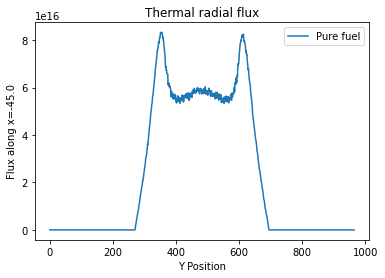

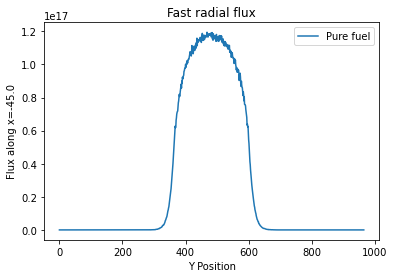

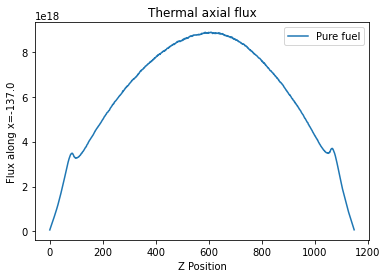

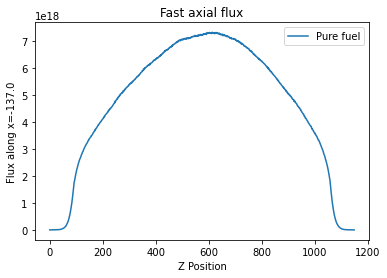

In [33]:
# Neutron flux for all base temperatures
for fuel in ['pure']:
        
        detectors = serpentTools.read(out_files['detectors'][fuel], 'det')
        radial = detectors.detectors['radial_flux']
        axial = detectors.detectors['axial_flux']
        
        plt.figure(counter)
        radial.plot(fixed={'energy':0, 'xmesh':438}, xlabel='Y Position',
                    ylabel = 'Flux along x={}'.format(radial.grids['X'][438,0]),
                    label=f"{fuel.capitalize()} fuel")
        plt.title(f"Thermal radial flux")
                    
        plt.figure(counter+1)
        radial.plot(fixed={'energy':1, 'xmesh':438}, xlabel='Y Position',
                    ylabel = 'Flux along x={}'.format(radial.grids['X'][438,0]),
                    label=f"{fuel.capitalize()} fuel")
        plt.title(f"Fast radial flux")
        
        plt.figure(counter+2)
        axial.plot(fixed={'energy':0}, label=f'{fuel.capitalize()} fuel', xlabel= 'Z Position',
                  ylabel = 'Flux along x={}'.format(axial.grids['Z'][438,0]))
        plt.title(f"Thermal axial flux")
                    
        plt.figure(counter+3)
        axial.plot(fixed={'energy':1}, label=f'{fuel.capitalize()} fuel', xlabel= 'Z Position',
                  ylabel = 'Flux along x={}'.format(axial.grids['Z'][438,0]))
        plt.title(f"Fast axial flux")

## Temperature feedback coefficients

In [23]:
rho = {'pure':{},'ebr2':{}, 'y12':{}}
rho_error = {'pure':{}, 'ebr':{}, 'y12':{}}
feedback = {'pure':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0},
             'ebr2':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}, 
             'y12':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}}
feedback_error = {'pure':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0},
             'ebr2':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}, 
             'y12':{'fuel':0, 'coolant':0, 'moderator':0, 'total':0}}
for key in rho:
    rho[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
    rho_error[key] = {'CCC':0, 'ACC':0, 'BCC':0, 'DCC':0, 'ECC':0, 'CAC':0, 'CBC':0,
                  'CDC':0, 'CEC':0, 'CCA':0, 'CCB':0, 'CCD':0, 'CCE':0, 'AAA':0,
                  'BBB':0, 'DDD':0, 'EEE':0}
for fuel in ['pure']: 
    for key in rho[fuel]:
        rho[fuel][key] = calculate_rho(k_eff[fuel][key])

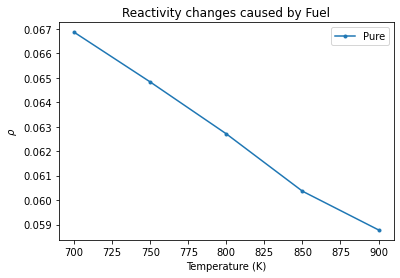

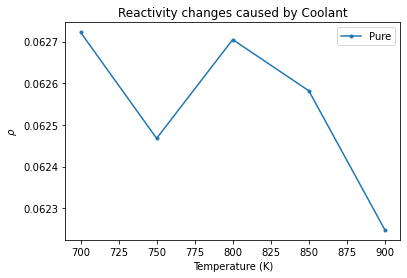

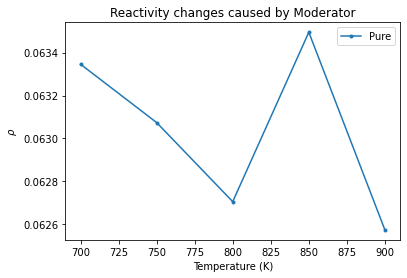

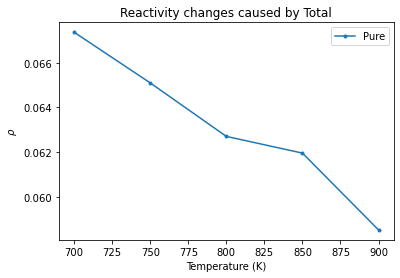

In [24]:
temps = [700, 750, 800, 850, 900]
for fuel in ['pure']:
    for m_index, material in enumerate(['fuel', 'coolant', 'moderator', 'total']):
        plt.figure(m_index)
        if material == 'fuel':
            data =[rho[fuel]['ACC'], rho[fuel]['BCC'], rho['pure']['CCC'], rho['pure']['DCC'], rho[fuel]['ECC']]
        if material == 'coolant':
            data =[rho[fuel]['CAC'], rho[fuel]['CBC'], rho['pure']['CCC'], rho['pure']['CDC'], rho[fuel]['CEC']]
        if material == 'moderator':
            data =[rho[fuel]['CCA'], rho[fuel]['CCB'], rho['pure']['CCC'], rho['pure']['CCD'], rho[fuel]['CCE']]
        if material == 'total':
            data =[rho[fuel]['AAA'], rho[fuel]['BBB'], rho['pure']['CCC'], rho['pure']['DDD'], rho[fuel]['EEE']]
        feedback[fuel][material] = calculate_m(temps, data)
        feedback_error[fuel][material] = calculate_m_error(temps, data)
        
        plt.plot(temps, data, 
                 marker='.', label=f"{fuel.capitalize()}")
        plt.legend()
        plt.title(f"Reactivity changes caused by {material.capitalize()}")
        plt.xlabel('Temperature (K)')
        plt.ylabel(r'$\rho$')

In [36]:
for fuel in feedback:
    for material in feedback[fuel]:
        print(fuel, material, feedback[fuel][material]*1e5, "+/-",
             feedback_error[fuel][material]*1e5)

pure fuel -4.124895697753891 +/- 0.12780451445892005
pure coolant -0.16699934627667973 +/- 0.10519056075882002
pure moderator -0.22483784810792715 +/- 0.2596076178492783
pure total -4.164725128361897 +/- 0.40383915148746974
ebr2 fuel 0.0 +/- 0.0
ebr2 coolant 0.0 +/- 0.0
ebr2 moderator 0.0 +/- 0.0
ebr2 total 0.0 +/- 0.0
y12 fuel 0.0 +/- 0.0
y12 coolant 0.0 +/- 0.0
y12 moderator 0.0 +/- 0.0
y12 total 0.0 +/- 0.0


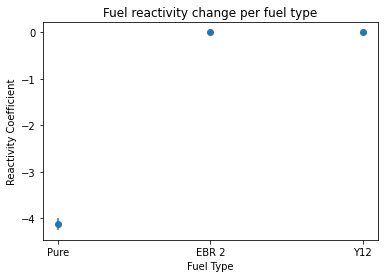

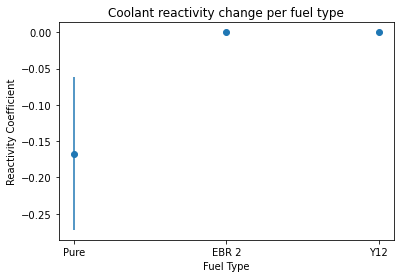

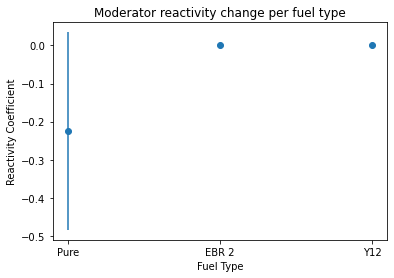

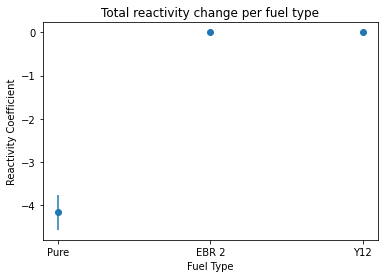

In [38]:
for m_index, material in enumerate(feedback['pure']):
    plt.figure(m_index)
    plt.errorbar(['Pure', 'EBR 2', 'Y12'], [feedback['pure'][material]*1e5, 
                                            feedback['ebr2'][material]*1e5, 
                                            feedback['y12'][material]*1e5],
                yerr = [feedback_error['pure'][material]*1e5, 
                        feedback_error['ebr2'][material]*1e5,
                        feedback_error['y12'][material]],
                linestyle='None', marker = 'o')
    plt.xlabel('Fuel Type')
    plt.ylabel('Reactivity Coefficient')
    plt.title(f'{material.capitalize()} reactivity change per fuel type')